In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Importing zipfile to unzip dataset
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "Ingredients" #name of the folder we want to unzip to

# If the image folder doesn't exist, create new file...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Unzip Expression data
with zipfile.ZipFile("/content/data/Ingredients.zip", "r") as zip_ref:
        print("Unzipping Expression data...")
        zip_ref.extractall(image_path)

data/Ingredients directory exists.
Unzipping Expression data...


In [ ]:
image_path = data_path / "Ingredients"

# Walkthrough the data to check the length of each directories
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/Ingredients'.
There are 5 directories and 0 images in 'data/Ingredients/Train'.
There are 0 directories and 160 images in 'data/Ingredients/Train/Rice'.
There are 0 directories and 160 images in 'data/Ingredients/Train/Eggs'.
There are 0 directories and 160 images in 'data/Ingredients/Train/Meat'.
There are 0 directories and 160 images in 'data/Ingredients/Train/Chicken'.
There are 0 directories and 160 images in 'data/Ingredients/Train/Potato'.
There are 5 directories and 0 images in 'data/Ingredients/Test'.
There are 0 directories and 40 images in 'data/Ingredients/Test/Rice'.
There are 0 directories and 40 images in 'data/Ingredients/Test/Eggs'.
There are 0 directories and 40 images in 'data/Ingredients/Test/Meat'.
There are 0 directories and 40 images in 'data/Ingredients/Test/Chicken'.
There are 0 directories and 40 images in 'data/Ingredients/Test/Potato'.


In [ ]:
# Define transformations
data_transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.RandomRotation(degrees=15),
     transforms.RandomHorizontalFlip(),
     transforms.CenterCrop(size=224),
     transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

In [ ]:
# Use torchvision.datasets.ImageFolder to create dataset(s)
from torchvision import datasets

# Setup train and testing paths
train_dir = image_path / "/content/data/Ingredients/Train"
test_dir = image_path / "/content/data/Ingredients/Test"


train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 800
    Root location: /content/data/Ingredients/Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(224, 224))
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 200
    Root location: /content/data/Ingredients/Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(22

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

# Create iterators for the Data loaded using DataLoader module
batchSize = 4

trainloader = DataLoader(dataset=train_data, batch_size=batchSize, num_workers=1, shuffle=True)
testloader = DataLoader(dataset=test_data, batch_size=batchSize, num_workers=1, shuffle=False)

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

800
200


In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 5)

# LOSS AND OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Check for NaN/Inf in model weights before moving to GPU
for name, param in model.named_parameters():
    if torch.isnan(param).any() or torch.isinf(param).any():
        print(f"Found NaN/Inf in {name}")

# move the model to GPU (with error handling)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
try:
    model.to(device)
    print("Model moved to GPU successfully.")
except RuntimeError as e:
    print(f"Error moving model to GPU: {e}")

Model moved to GPU successfully.


In [ ]:
import time
from tqdm.auto import tqdm

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    # accuracy = torchmetrics.Accuracy(device=device)
    # Initialize the accuracy metric from torchmetrics
    # accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10).to(device)

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'Ingredients.pt')

    return best_model, history

In [ ]:
# Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, loss_fn, optimizer, trainloader, testloader, num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 0.3290, Accuracy: 89.0000%, 
		Validation : Loss : 0.0443, Accuracy: 99.0000%, Time: 11.4780s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.1296, Accuracy: 95.8750%, 
		Validation : Loss : 0.0821, Accuracy: 98.5000%, Time: 9.9336s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.0655, Accuracy: 98.2500%, 
		Validation : Loss : 0.0369, Accuracy: 98.5000%, Time: 10.8764s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.0815, Accuracy: 97.5000%, 
		Validation : Loss : 0.0159, Accuracy: 99.0000%, Time: 8.8442s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.0487, Accuracy: 98.5000%, 
		Validation : Loss : 0.1117, Accuracy: 98.5000%, Time: 9.8381s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1251, Accuracy: 96.7500%, 
		Validation : Loss : 0.0671, Accuracy: 98.5000%, Time: 9.8713s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.0680, Accuracy: 98.2500%, 
		Validation : Loss : 0.0250, Accuracy: 99.0000%, Time: 9.8391s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.0820, Accuracy: 9

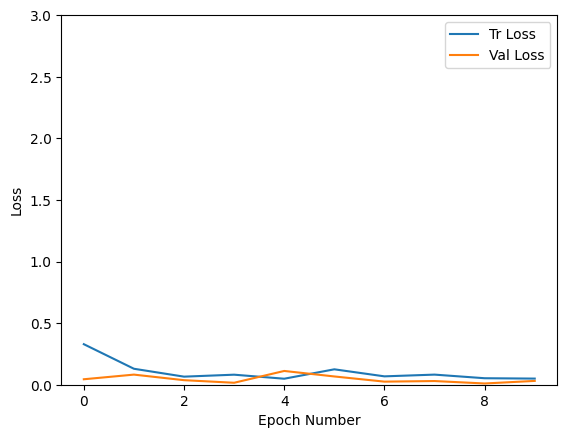

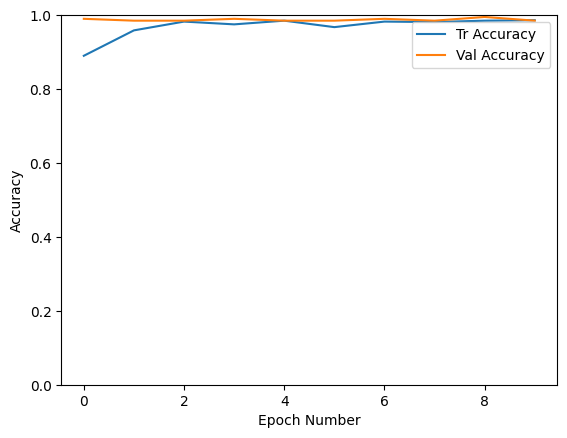

In [ ]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('Gender_loss_curve.png')
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('Gender_accuracy_curve.png')
plt.show()